In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [4]:
X1 = train_data.drop(columns = ['Name','PassengerId','Cabin','Survived'],axis=1)
y1 = train_data.Survived
X_test = test_data.drop(columns =  ['PassengerId','Name','Ticket','Cabin'],axis=1)

In [5]:
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X1,y1,train_size=0.8,test_size=0.2,random_state=1)

In [6]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
301,3,male,NaN,2,0,367226,23.2500,Q
309,1,female,30.0,0,0,PC 17485,56.9292,C
516,2,female,34.0,0,0,C.A. 34260,10.5000,S
120,2,male,21.0,2,0,S.O.C. 14879,73.5000,S
570,2,male,62.0,0,0,S.W./PP 752,10.5000,S


# deal with missing value

In [7]:
X_train.isnull().sum()

Pclass        0
Sex           0
Age         144
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
dtype: int64

In [8]:
X_test.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [9]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")

In [10]:
for col in ['Age','Fare']:
    X_train[col] = num_imputer.fit_transform(X_train[[col]])
    X_valid[col] = num_imputer.fit_transform(X_valid[[col]])
    X_test[col] = num_imputer.fit_transform(X_test[[col]])
X_train['Embarked'] = cat_imputer.fit_transform(X_train[['Embarked']].values)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# deal with categorical data

In [11]:
X_train = X_train.drop(columns = ['Ticket'],axis=1)
X_valid = X_valid.drop(columns = ['Ticket'],axis=1)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
301,3,male,30.166232,2,0,23.2500,Q
309,1,female,30.000000,0,0,56.9292,C
516,2,female,34.000000,0,0,10.5000,S
120,2,male,21.000000,2,0,73.5000,S
570,2,male,62.000000,0,0,10.5000,S


In [12]:
def family(df):
    df['Family'] = df['SibSp'] + df['Parch']
    df = df.drop(columns=['SibSp','Parch'],axis=1)
    return df
X_train = family(X_train)
X_valid = family(X_valid)
X_test = family(X_test)

In [13]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown="ignore",sparse=False)

In [14]:

def one_hot(X):
    ohe_cols = ['Pclass','Sex','Embarked']
    ohe_cols_train = pd.DataFrame(one_hot_encoder.fit_transform(X[ohe_cols]))
    ohe_cols_train.index = X.index
    XX = X.drop(ohe_cols,axis=1)
    return pd.concat([XX,ohe_cols_train],axis=1)

In [15]:
X_ohe_train = one_hot(X_train)
X_ohe_valid = one_hot(X_valid)
X_ohe_test = one_hot(X_test)

In [16]:
X_ohe_train.rename(columns={0:"Pclass_1",1:"Pclass_2",2:"Pclass_3",3:"Sex_female",4:"Sex_male",5:"Embarked_C",6:"Embarked_Q",7:"Embarked_S"},inplace=True)
X_ohe_valid.rename(columns={0:"Pclass_1",1:"Pclass_2",2:"Pclass_3",3:"Sex_female",4:"Sex_male",5:"Embarked_C",6:"Embarked_Q",7:"Embarked_S"},inplace=True)
X_ohe_test.rename(columns={0:"Pclass_1",1:"Pclass_2",2:"Pclass_3",3:"Sex_female",4:"Sex_male",5:"Embarked_C",6:"Embarked_Q",7:"Embarked_S"},inplace=True)

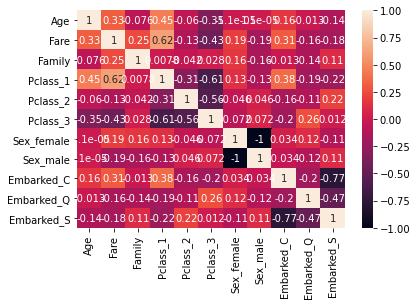

In [17]:
sns.heatmap(X_ohe_test.corr(),annot=True)

In [18]:
# normalization 
from sklearn.preprocessing import MinMaxScaler
normalize = MinMaxScaler()

def normalize_feature(df):
    normalize_cols = ['Age','Fare']
    df_new = pd.DataFrame()
    for cols in normalize_cols:
        X_scaled = normalize.fit_transform(np.array(df[cols]).reshape(-1,1))
        df_scaled = pd.DataFrame(X_scaled,columns = [cols+'_new'])
        df_new = pd.concat([df_scaled,df_new],axis=1)
    df = pd.concat([df,df_new],axis=1)
    df.drop(columns=['Age','Fare'],axis=1,inplace=True)
    return df

In [19]:
X_new_train = normalize_feature(X_ohe_train)
X_new_valid = normalize_feature(X_ohe_valid)
X_new_test  = normalize_feature(X_ohe_test)

In [20]:
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(X_new_train.corr(),annot=True)
plt.title("correlation chart")
plt.show()

NameError: name 'plt' is not defined

In [21]:
# random forest model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix,accuracy_score

In [22]:
model = RandomForestClassifier()
model.fit(X_ohe_train,y_train)
pred = model.predict(X_ohe_valid)
print("Confusion_matrix:\n",confusion_matrix(pred,y_valid))
print("Accuracy:",accuracy_score(pred,y_valid))

Confusion_matrix:
 [[94 28]
 [12 45]]
Accuracy: 0.776536312849162


In [23]:
from sklearn.model_selection import GridSearchCV
params= {'n_estimators':[50,100,150,200,300,400,500,700,800,1000],
         'max_depth':[2,3,4,5],
         'min_samples_split':[2,3,4,5]}
grid = GridSearchCV(model,param_grid=params,cv=5)
result = grid.fit(X_ohe_train,y_train)
print(result.best_params_)
print(result.best_score_)

{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 400}
0.845562887816409


In [24]:
rf_model = RandomForestClassifier(max_depth=5,min_samples_split=4,n_estimators=800)
rf_model.fit(X_ohe_train,y_train)
rf_predict = rf_model.predict(X_ohe_valid)
print(confusion_matrix(y_valid,rf_predict))

[[99  7]
 [33 40]]


In [25]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)

NameError: name 'predictions' is not defined

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold

model = LogisticRegression()
solvers = ['newton-cg','lbfgs','liblinear','sag','saga']
panelty = ['l2','l1','none','elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
# parameters = dict(solver=solvers,panalty=panalty,C=c_values)
# model.get_params().keys()
grid = dict(solver=solvers,penalty=panelty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search.fit(X_ohe_train,y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.8075834637454355


In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_ohe_train,y_train)
predict = knn.predict(X_ohe_valid)

In [28]:
print(confusion_matrix(predict,y_valid))
print(classification_report(predict,y_valid))

[[81 36]
 [25 37]]
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       117
           1       0.51      0.60      0.55        62

    accuracy                           0.66       179
   macro avg       0.64      0.64      0.64       179
weighted avg       0.68      0.66      0.66       179



In [29]:
error_rate = []
for i in range(1,200):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_ohe_train,y_train)
    predict = knn.predict(X_ohe_valid)
    error_rate.append(np.mean(predict != y_valid))

In [30]:
print(error_rate)

[0.3407821229050279, 0.329608938547486, 0.25139664804469275, 0.31843575418994413, 0.2569832402234637, 0.31843575418994413, 0.2849162011173184, 0.30726256983240224, 0.30726256983240224, 0.329608938547486, 0.30726256983240224, 0.30726256983240224, 0.30726256983240224, 0.3128491620111732, 0.3128491620111732, 0.30726256983240224, 0.30726256983240224, 0.3128491620111732, 0.3016759776536313, 0.3128491620111732, 0.31843575418994413, 0.3016759776536313, 0.30726256983240224, 0.31843575418994413, 0.3407821229050279, 0.329608938547486, 0.33519553072625696, 0.30726256983240224, 0.3407821229050279, 0.3240223463687151, 0.31843575418994413, 0.3407821229050279, 0.3407821229050279, 0.3407821229050279, 0.3407821229050279, 0.36312849162011174, 0.3463687150837989, 0.3463687150837989, 0.35195530726256985, 0.36312849162011174, 0.3575418994413408, 0.3743016759776536, 0.3687150837988827, 0.36312849162011174, 0.3575418994413408, 0.3854748603351955, 0.3687150837988827, 0.37988826815642457, 0.37988826815642457, 

In [31]:
plt.figure(figsize=(15,6))
plt.plot(range(1,200),error_rate,color='blue',linestyle="dashed",marker="o",markerfacecolor="red",markersize=10)
plt.plot()

NameError: name 'plt' is not defined

In [32]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
n = [range(1,200)]
param = dict(n_neighbors=range(1,200))
grid = GridSearchCV(knn,param,cv=5)
grid.fit(X_ohe_train,y_train)
print(grid.best_params_)
print(grid.best_estimator_)

{'n_neighbors': 17}
KNeighborsClassifier(n_neighbors=17)
